In [771]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
alpha = 0.4 # Capital share of output
beta = 0.97 # Discount factor
rho = 0.9 # Persistence of technology shock
sigma = 0.1 # Standard deviation of technology shock
phi = 0.5 # Calvo parameter
theta = 2.5 # Elasticity of substitution
pi_star = 1 # Target inflation rate %
delta = 0.55 # Depreciation rate
s = 0.1 # Share of firms that can adjust prices

In [772]:
# Steady-state values
k_star = ((1/beta - 1 + alpha) / alpha)**(1 / (alpha - 1)) #steady-state level of the capital stock
c_star = (1 - alpha) * y_star / (1 - beta * (1 - delta)) #steady-state level of consumption
i_star = beta * (1 - delta) * y_star #steady-state level of investment
y_star = k_star ** alpha #steady-state level of output

print("Steady-State Values:")
print("Capital Stock:", k_star)
print("Consumption:", c_star)
print("Interest:", i_star)
print("Output:", y_star)

Steady-State Values:
Capital Stock: 0.8832678164277818
Consumption: 1.0131979269847313
Interest: 0.41535669067516445
Output: 0.9515617197598271


In [773]:
# Grid for capital stock
k_min = 0.9 * k_star
k_max = 1.1 * k_star
num_points = 1000
num_firms = 100
k_grid = np.linspace(k_min, k_max, num_points)

We try households to maximize their utility, which is often assumed to be a function of consumption. In this case, the utility function is assumed to be logarithmic (u = np.log(c)), and the marginal utility is the derivative of the utility function with respect to consumption (u_prime = 1 / c).

By calling the household_optimization function within the main loop of your code and passing the appropriate variables, you can incorporate the optimization problem into your model. The specific implementation and use of the optimization result depend on the context and objectives of your model.

In [774]:
# Household optimization
def household_optimization(c, k, y, i, delta):
    # Utility parameters
    gamma = 2.0  # Relative risk aversion
    beta = 0.95  # Discount factor
    
    # Marginal utility of consumption
    u_prime = c**(-gamma)
    
    # Euler equation
    euler_eq = u_prime / (beta * (1 - delta) * u_prime)
    
    return euler_eq

Simplified Calvo pricing assumptionintroduces nominal rigidities by assuming that only a fraction of firms can adjust their prices in a given period. The remaining firms face price stickiness and keep their prices unchanged.
The Calvo assumption simplifies price adjustment dynamics by assuming that price-setters have a fixed probability (share s) of resetting their prices in each period.The remaining firms continue to apply their previous prices, subject to aggregate price level movements.

In [775]:
def calvo_price_update(p, pi, s, sigma):
    num_firms = p.shape[1]
    p_tilde = ((1 - s) * np.exp(pi) + s * np.mean(p)) ** (1 / (1 - s))

    for j in range(num_firms):
        if np.random.uniform() < s:
            p[:, j] = p_tilde * np.exp(np.random.normal(0, sigma, size=p.shape[0]))
    
    return p

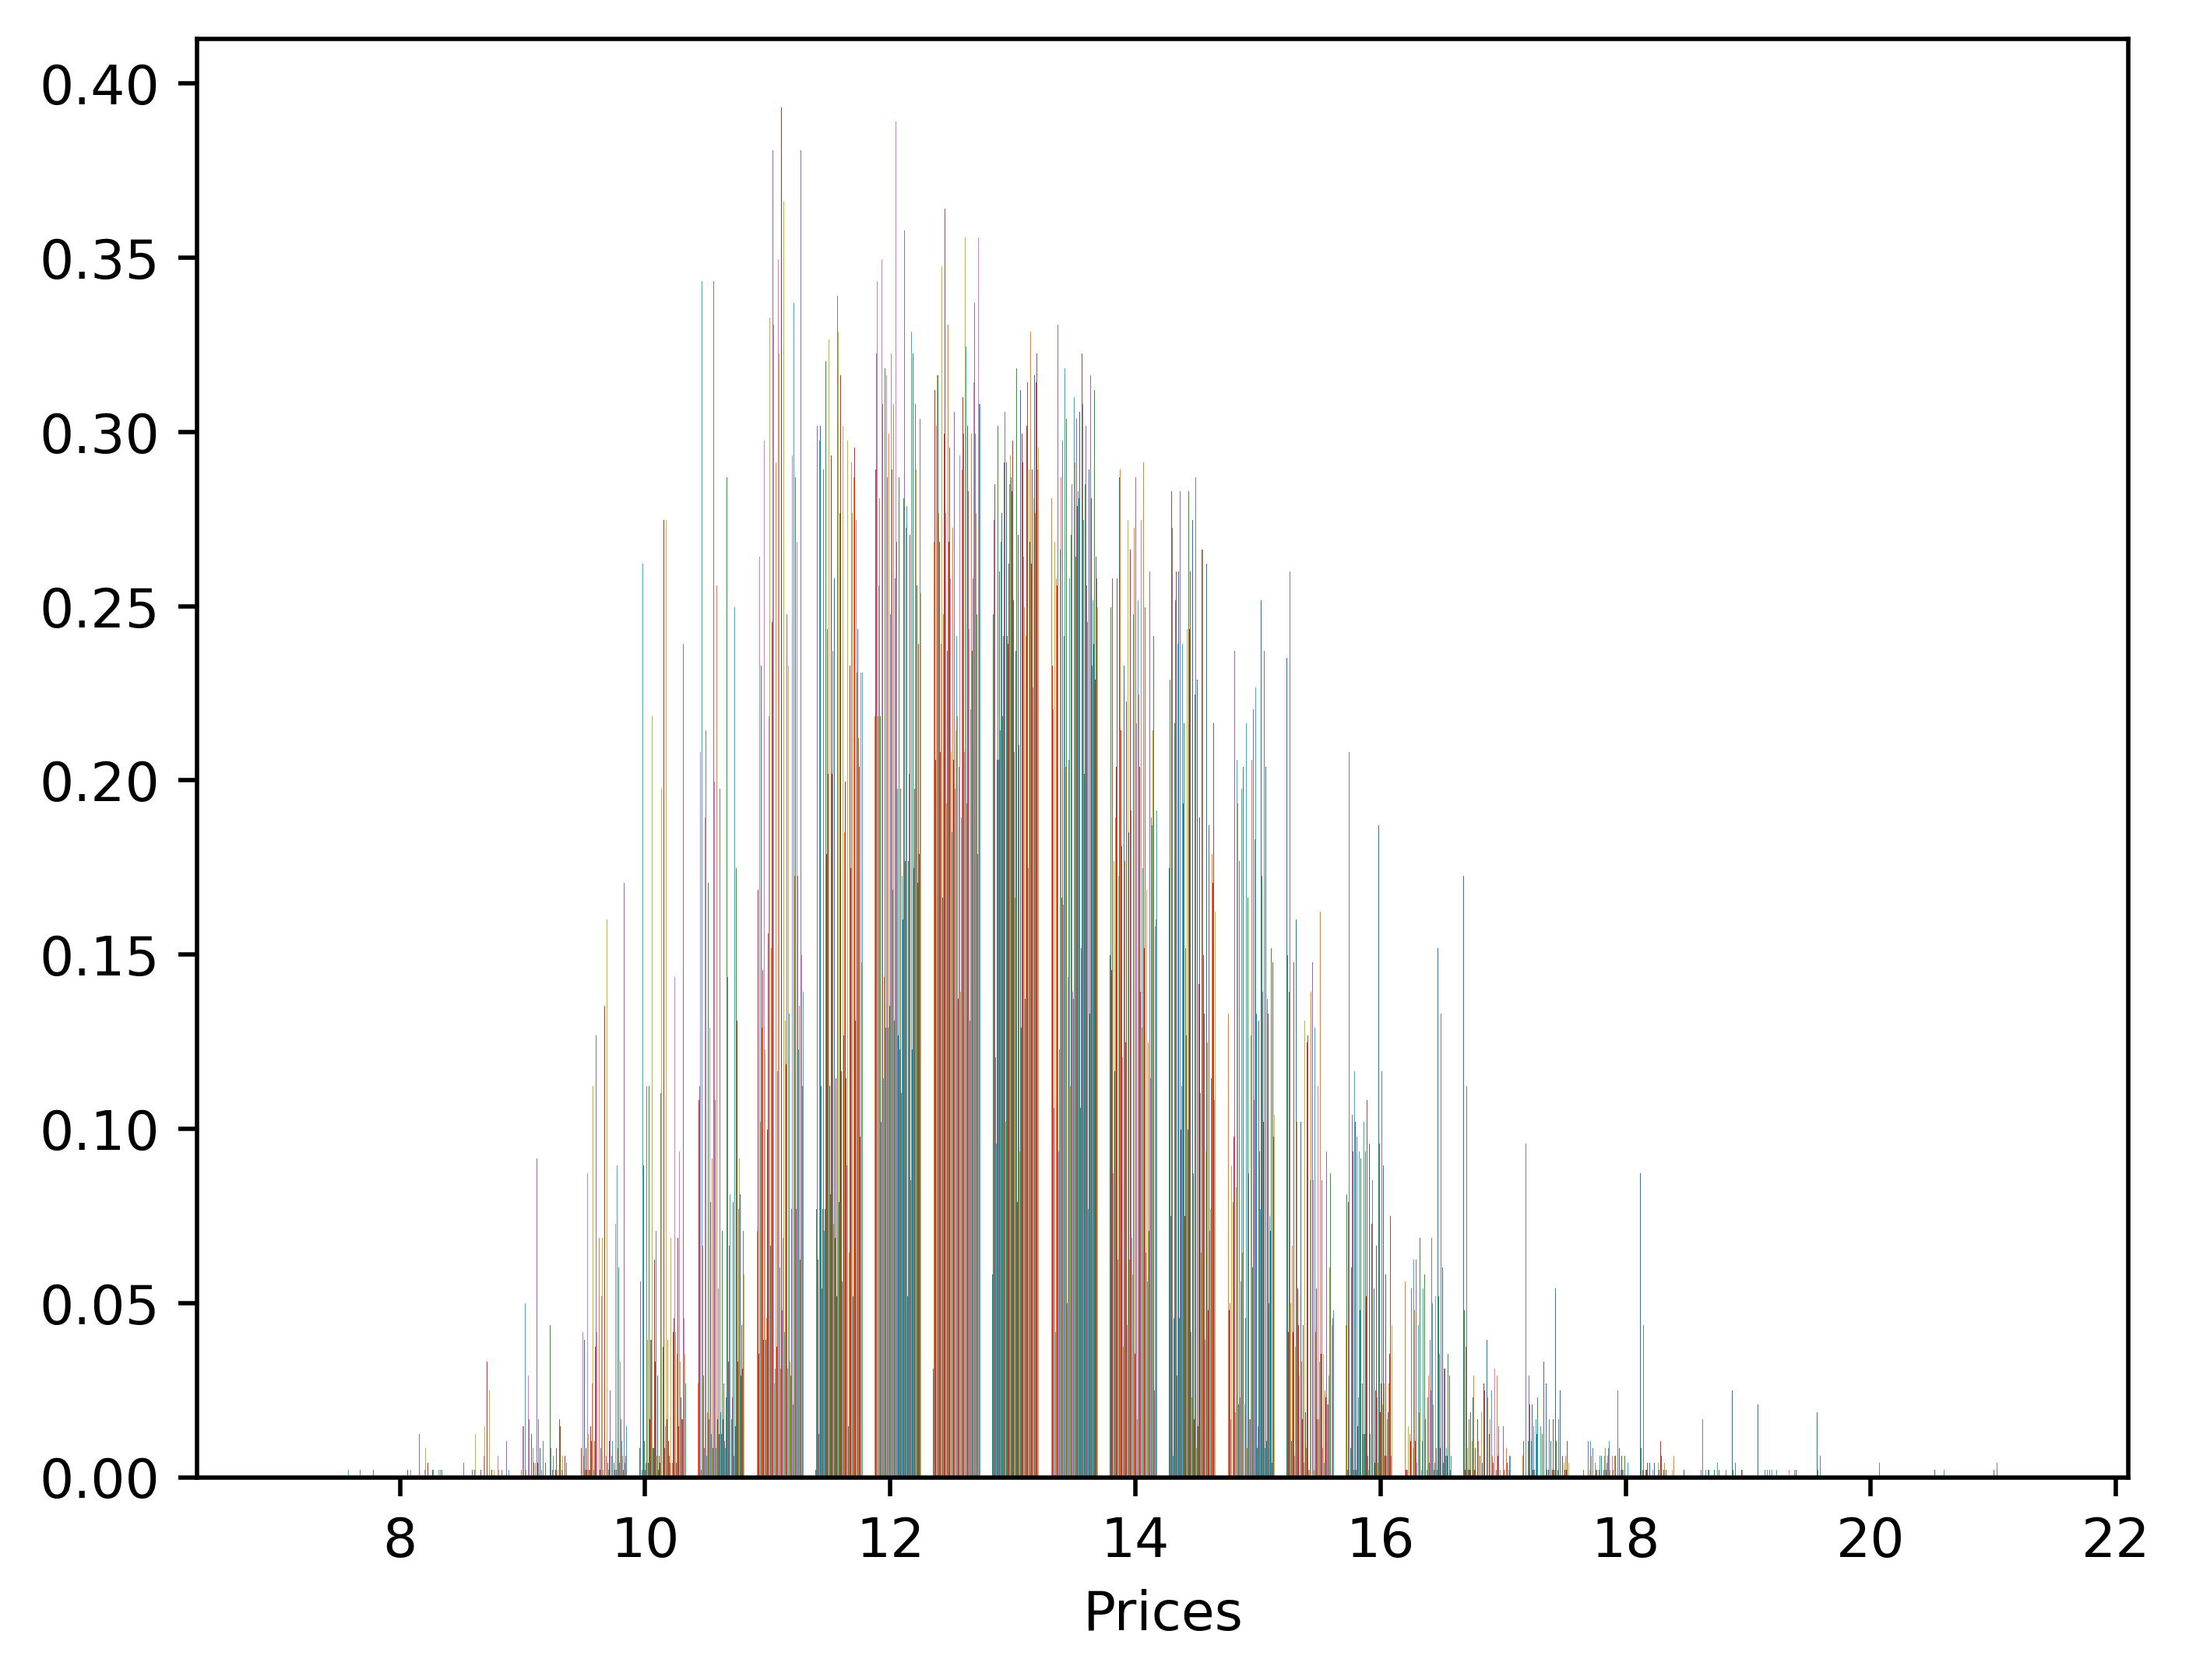

In [776]:
# Plot distribution of inflation
plt.figure()
plt.hist(p, bins=30, density=True)
plt.xlabel('Prices')

plt.show()

In [777]:
# Create matrices for state variables and shocks
z = np.zeros(num_points) # Technology shock
e = np.random.normal(0, sigma, num_points) # Innovation to technology shock
k = np.zeros(num_points) # Capital stock
c = np.zeros(num_points) # Consumption
i = np.zeros(num_points) # Investment
pi = np.zeros(num_points) # Inflation
y = np.zeros(num_points) # Output
p = np.random.uniform(0.9, 1.1, size=(num_points, num_firms))  # Price initialization

In [778]:
# Initialize variables
k[0] = k_star
c[0] = c_star
i[0] = i_star
pi[0] = 0
y[0] = y_star


Here the formula follows a standard Cobb-Douglas production function, where output is determined by the capital stock raised to the power of the capital share (alpha) and multiplied by a technology shock term.
Basically, The production function assumes constant returns to scale and that the capital stock is greater than zero (to avoid division by zero). The technology shock captures exogenous changes in productivity.

Also, the inflation equation incorporates several factors. The lagged inflation term captures the persistence of inflation. The second term represents the target inflation rate, which acts as an anchor for inflation expectations. The third term introduces a Phillips curve relationship by considering the deviation of consumption relative to output from their steady-state levels. The last term captures the impact of the technology shock on inflation.

In [782]:
# Iterate over time periods
for t in range(1, num_points):
    # Update technology shock
    z[t] = rho * z[t-1] + e[t]
    
    # Compute output and inflation
    #y[t] = k[t-1]**alpha * np.exp((1-alpha)*z[t]) * (k[t-1] > 0) * (k[t-1]**alpha > 0)  # Output
    y[t] = k[t-1]**(alpha) * (np.exp(z[t]))**(1-alpha) * (k[t-1] > 0) * (k[t-1]**(alpha) > 0) # Output (Cobb - Douglas)
    pi[t] = phi * pi[t-1] + (1 - phi) * pi_star + theta * (c[t-1] / y[t-1] - c_star / y_star) + z[t] * sigma # Inflation
    
    # Compute consumption and investment
    c[t] = (1 - alpha) * y[t] + alpha * k[t] - i[t-1]  # Consumption
    i[t] = beta * i[t-1] + (1 - beta) * (c[t] - c[t-1])  # Investment
    
    # Call household optimization function
    euler_eq = household_optimization(c[t], k[t], y[t], i[t], delta) 
        
    # Update prices
    p = calvo_price_update(p, pi[t-1], s, sigma)
    
    # Compute aggregate price level
    p_tilde = ((1-s)*np.exp(pi[t-1]) + s*np.mean(p[t-1,:]))**(1/(1-s))
    
    # Update prices for firms that can adjust
    for j in range(num_firms):
        if np.random.uniform() < s:
            p[t,j] = p_tilde * np.exp(np.random.normal(0, sigma))
    
    # Update capital stock
    k[t] = i[t] + (1 - delta) * k[t-1] + y[t]

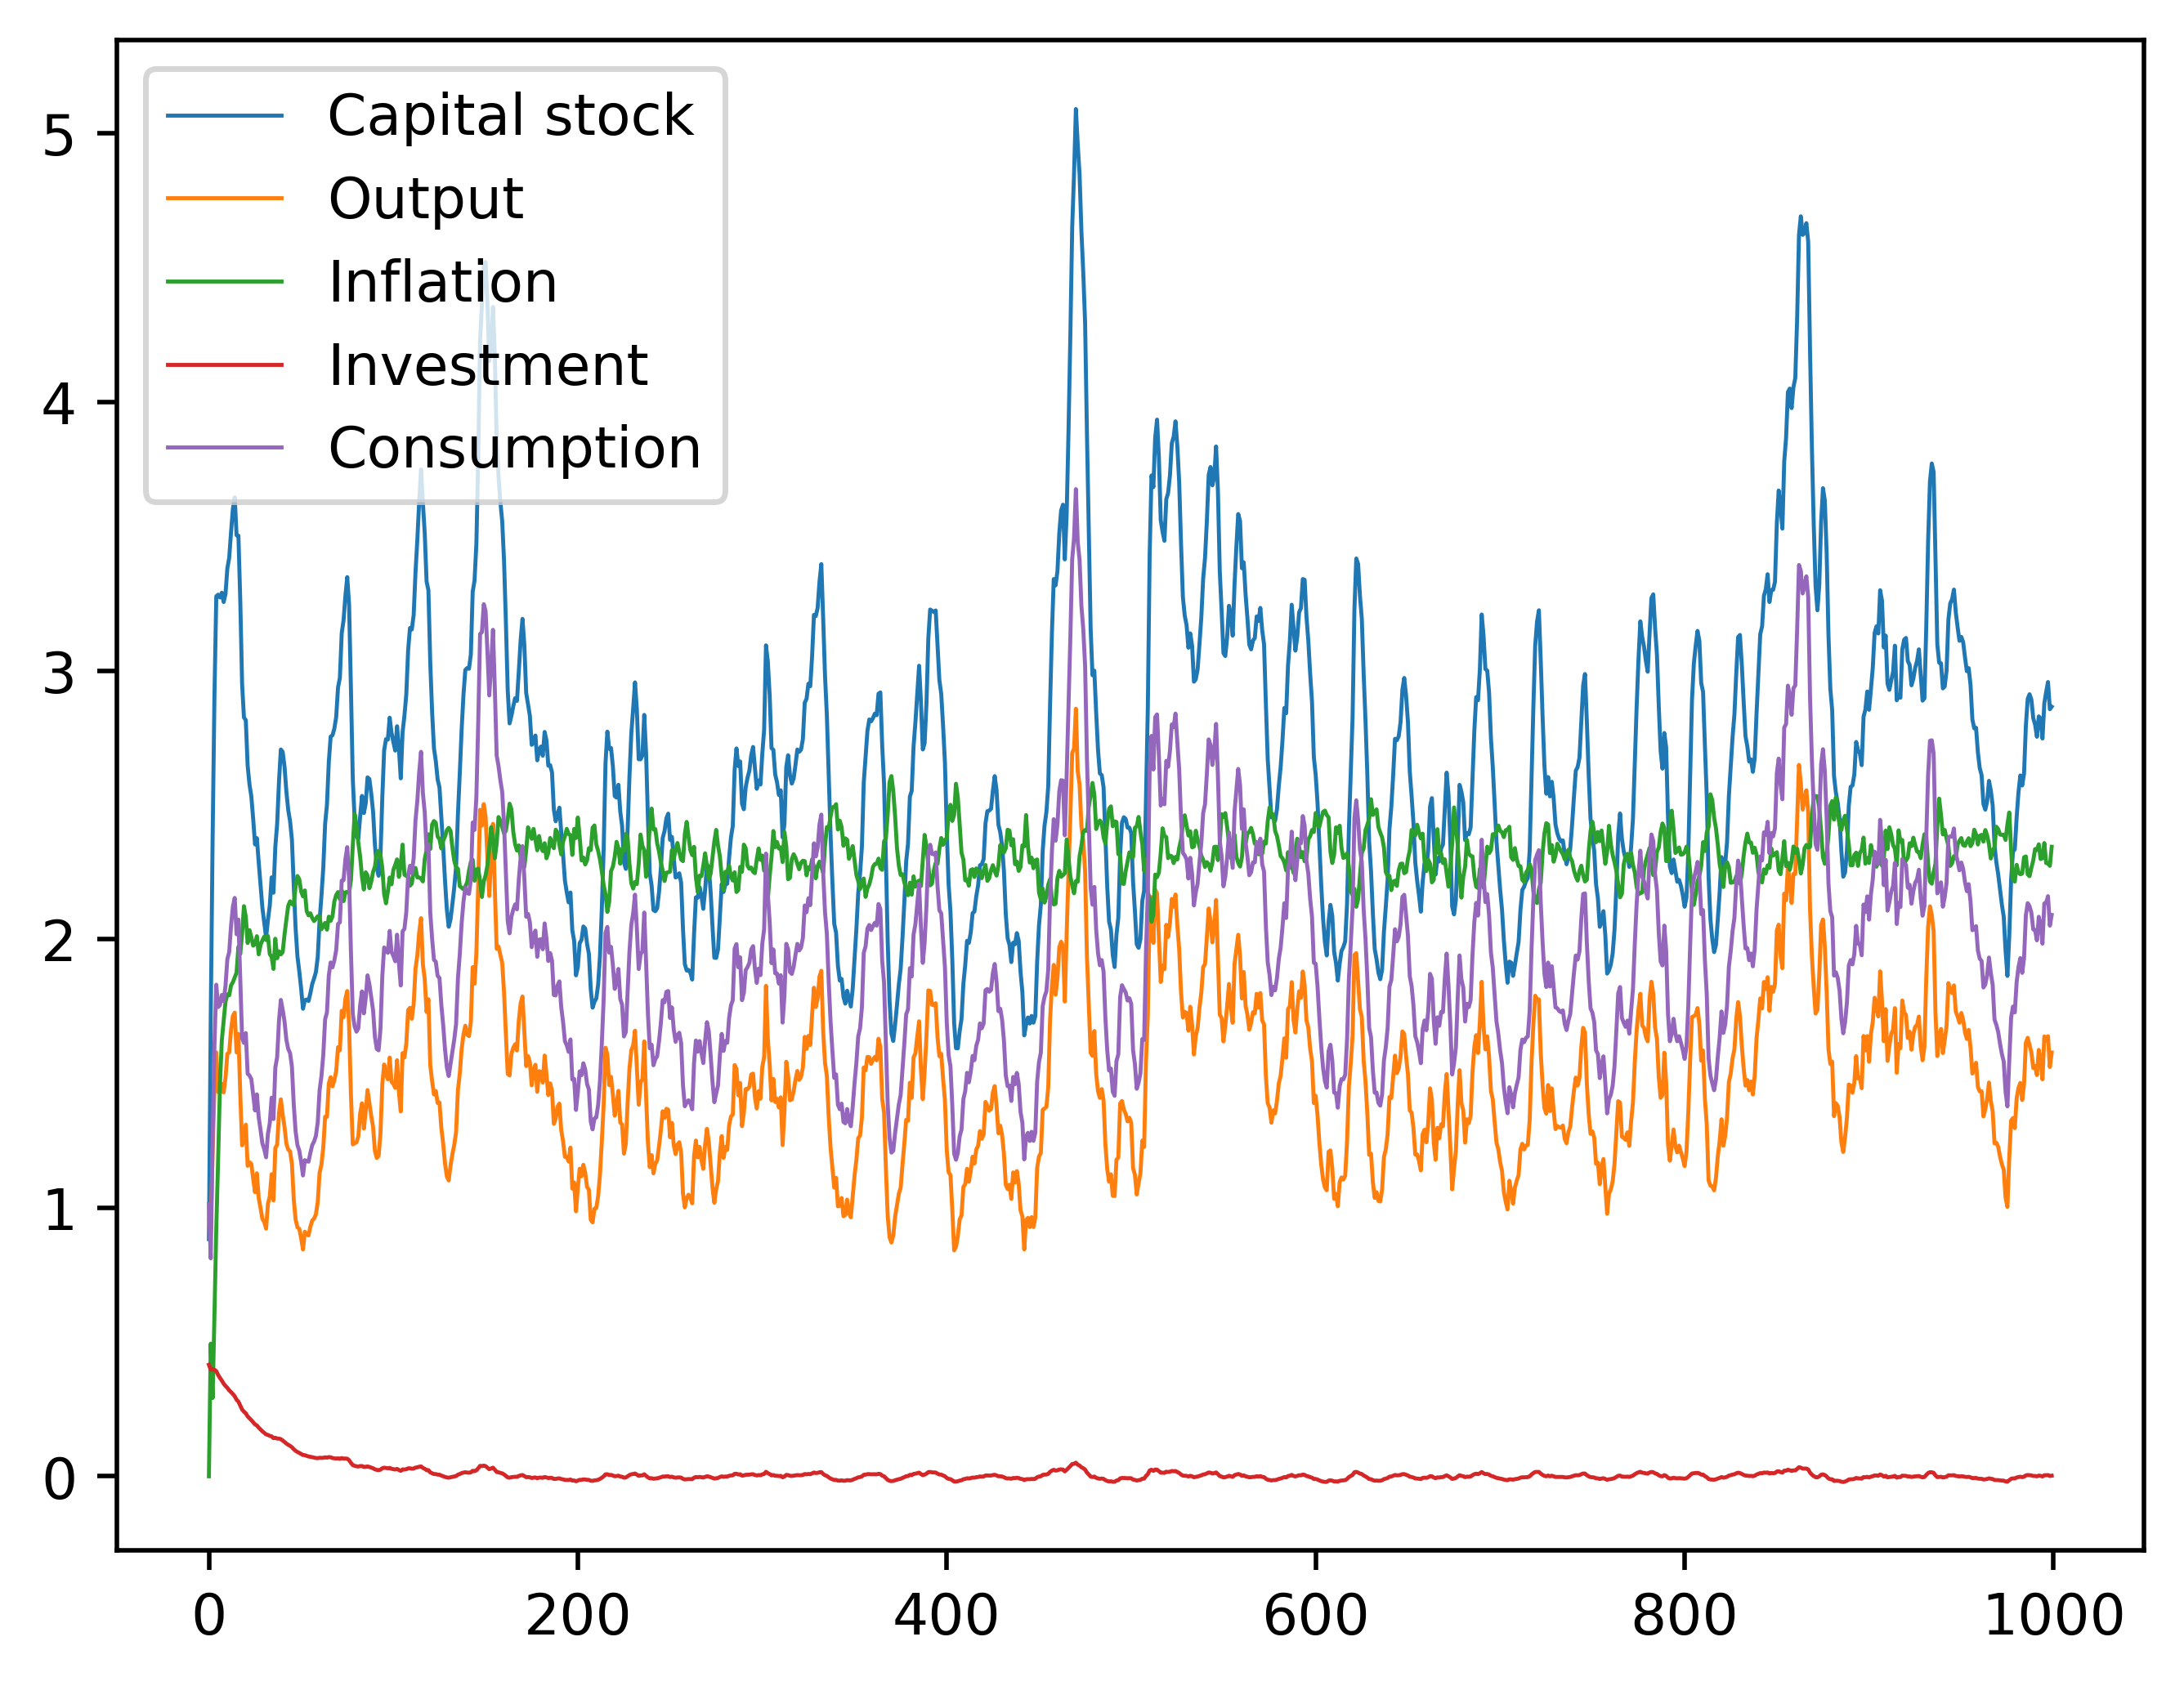

In [783]:
# Plot results with thinner lines
plt.plot(k, label='Capital stock', linewidth=0.7)
plt.plot(y, label='Output', linewidth=0.7)
plt.plot(pi, label='Inflation', linewidth=0.7)
plt.plot(i, label='Investment', linewidth=0.7)
plt.plot(c, label='Consumption', linewidth=0.7)

plt.rcParams['figure.dpi'] = 500
plt.legend()

plt.show()

Investment is low, because this model is simple and doesn't have a household optimization yet.

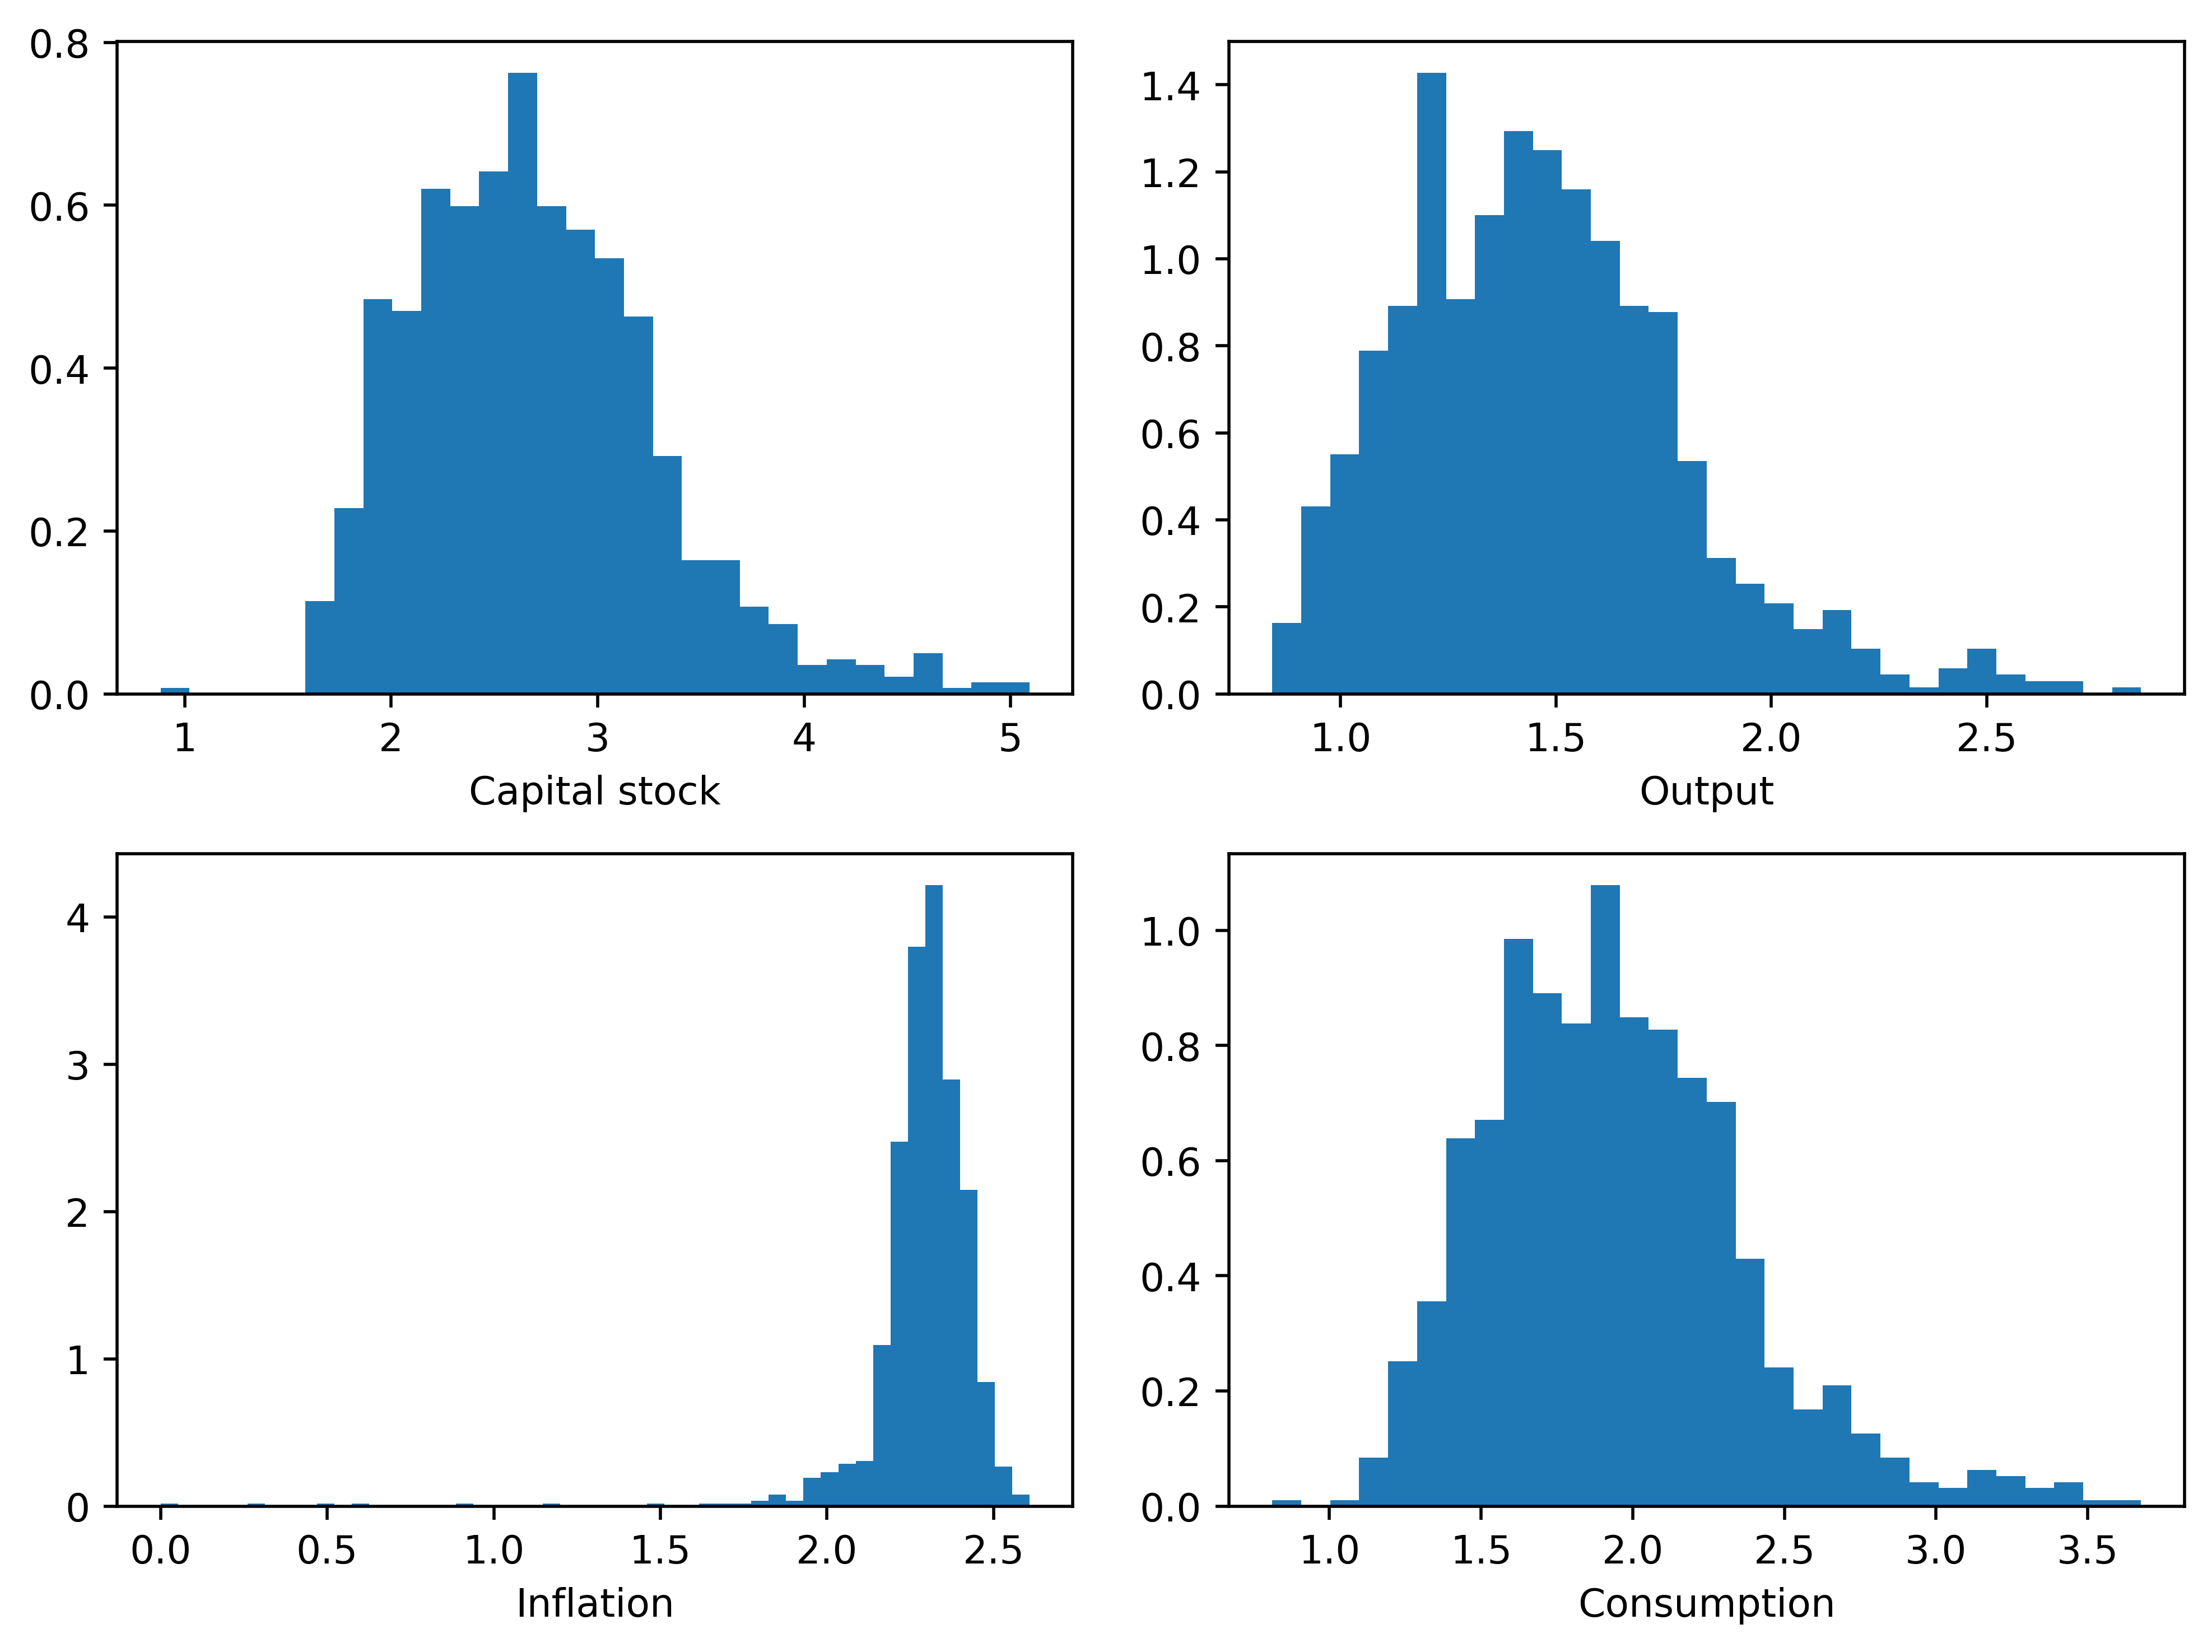

In [784]:
import matplotlib.pyplot as plt

# Set the desired figure size
fig_size = (8, 6)

# Create a grid layout for subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=fig_size)

# Plot distribution of Capital stock
axes[0, 0].hist(k, bins=30, density=True)
axes[0, 0].set_xlabel('Capital stock')

# Plot distribution of Output
axes[0, 1].hist(y, bins=30, density=True)
axes[0, 1].set_xlabel('Output')

# Plot distribution of Inflation
axes[1, 0].hist(pi, bins=50, density=True)
axes[1, 0].set_xlabel('Inflation')

# Plot distribution of Consumption
axes[1, 1].hist(c, bins=30, density=True)
axes[1, 1].set_xlabel('Consumption')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()
